In [2]:
from darts.datasets import AirPassengersDataset, MonthlyMilkDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, smape, rmse
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts import TimeSeries
import numpy as np
import pandas as pd
import os
import darts

import torch
import matplotlib.pyplot as plt
%matplotlib inline

[2021-10-22 07:53:03,548] WARNING | darts.models | Support for AutoARIMA is not available. To enable it, install u8darts[pmdarima] or u8darts[all].
[2021-10-22 07:53:03,564] WARNING | darts.models | Support Facebook Prophet is not available. To enable it, install u8darts[prophet] or u8darts[all].


In [3]:
df = pd.read_csv("final_demand_19_yarab.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")
df["total_demand"]=df["total_demand"].astype("float64")
df["total_demand"]=df["total_demand"].interpolate()
df["HourlyDryBulbTemperature"]=df["HourlyDryBulbTemperature"].interpolate()
df["HourlyWetBulbTemperature"]=df["HourlyWetBulbTemperature"].interpolate()
df.isna().sum()

total_demand                0
HourlyDryBulbTemperature    0
HourlyWetBulbTemperature    0
holiday                     0
weekday                     0
dtype: int64

In [4]:
df.sample(3)

,total_demand,HourlyDryBulbTemperature,HourlyWetBulbTemperature,holiday,weekday
datetime,,,,,
2019-01-03 08:00:00,19052.762077,34.0,31.0,1,4
2019-10-21 12:00:00,23377.769792,65.0,54.0,0,1
2019-05-04 23:00:00,22383.354655,46.0,45.0,1,6


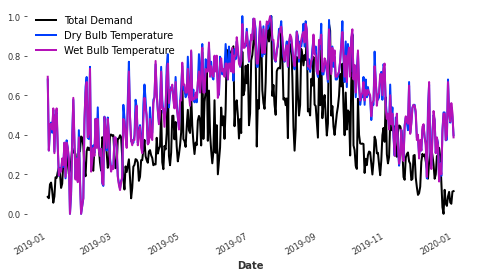

In [28]:


demand=TimeSeries.from_dataframe(df,None,"total_demand") #none here means that darts time series will use the index as the time index.
dry_temp=TimeSeries.from_dataframe(df,None,"HourlyDryBulbTemperature")
wet_temp=TimeSeries.from_dataframe(df,None,"HourlyWetBulbTemperature")
holiday=TimeSeries.from_dataframe(df,None,"holiday")
weekday=TimeSeries.from_dataframe(df,None,"weekday")

# normalise demand and temperature between 0 and 1

demand_19_per_day = demand.resample("D")
dry_temp_per_day = dry_temp.resample("D")
wet_temp_per_day = wet_temp.resample("D")            
                
scaler_demand, scaler_dry_temp, scaler_wet_temp = Scaler(), Scaler(), Scaler()
scaler_demand_scaled = scaler_demand.fit_transform(demand_19_per_day)
scaler_dry_temp_scaled = scaler_dry_temp.fit_transform(dry_temp_per_day)
scaler_wet_temp_scaled = scaler_wet_temp.fit_transform(wet_temp_per_day)

scaler_demand_scaled.plot(label='Total Demand')
scaler_dry_temp_scaled.plot(label='Dry Bulb Temperature')
scaler_wet_temp_scaled.plot(label='Wet Bulb Temperature')


plt.rcParams.update({'font.size': 10})
plt.rcParams["figure.figsize"] = (8, 4)

plt.grid(None)
plt.box(False)

plt.xlabel("Date")
plt.legend(loc="upper left", ncol=1);

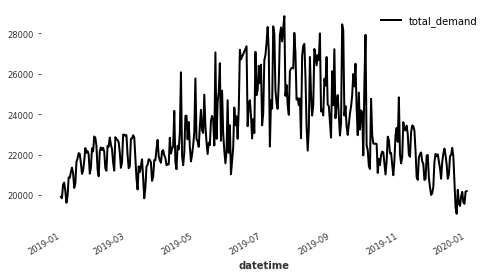

In [21]:
demand_19_per_day=demand.resample("D",method="pad")
demand_19_per_day.plot()

plt.grid(None)
plt.show()

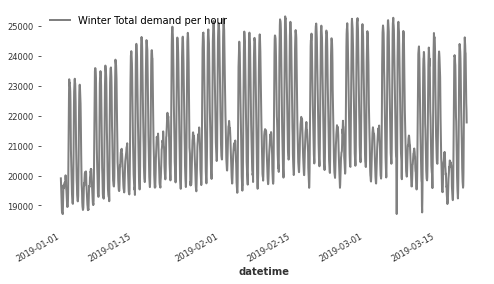

In [22]:
winter_demand_19=demand.slice(pd.to_datetime("2018-1-1"),pd.to_datetime("2019-03-21")) #the slicing is inclusive to the bounderies
winter_demand_19.resample("H",method="pad").plot(label="Winter Total demand per hour",color='grey')

plt.grid(None)
plt.legend(loc="upper left")

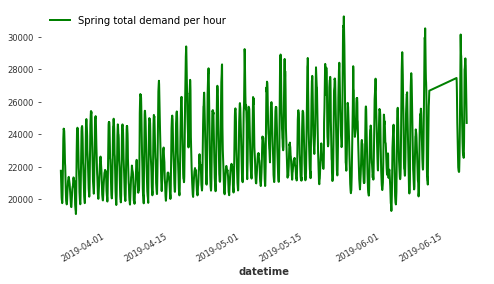

In [23]:
spring_demand_19=demand.slice(pd.to_datetime("2019-03-22"),pd.to_datetime("2019-06-20")) #the slicing is inclusive to the bounderies
spring_demand_19.resample("H",method="pad").plot(label="Spring total demand per hour",color='green')


plt.grid(None)
plt.legend(loc="upper left")

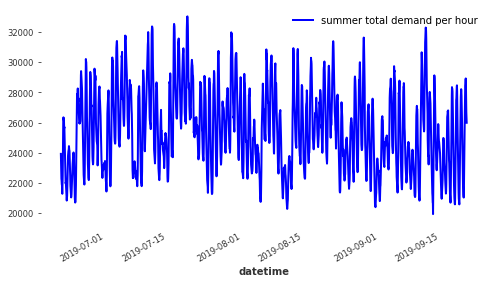

In [25]:
summer_demand_19=demand.slice(pd.to_datetime("2019-06-21"),pd.to_datetime("2019-09-21")) #the slicing is inclusive to the bounderies

summer_demand_19.resample("H",method="pad").plot(label="summer total demand per hour",color='blue')


plt.grid(None)
plt.legend(loc="upper right")


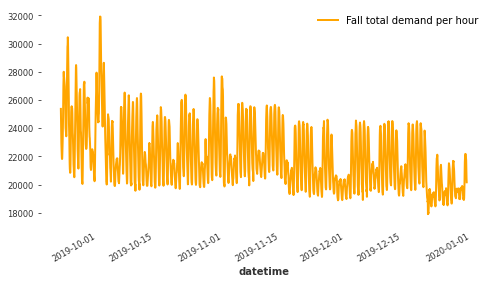

In [27]:
fall_demand_19=demand.slice(pd.to_datetime("2019-09-22"),pd.to_datetime("2019-12-31")) #the slicing is inclusive to the bounderies

fall_demand_19.resample("H",method="pad").plot(label="Fall total demand per hour",color='orange')

plt.grid(None)
plt.legend(loc="upper right")



# modeling

## preprocessing

In [67]:
df = pd.read_csv("final.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df = df.set_index("datetime")

df["total_demand"]=df["total_demand"].interpolate()
df["total_demand"]=df["total_demand"].apply(lambda x: np.round(x, 0))
df["HourlyDryBulbTemperature"]=df["HourlyDryBulbTemperature"].interpolate()
df["HourlyWetBulbTemperature"]=df["HourlyWetBulbTemperature"].interpolate()

demand=TimeSeries.from_dataframe(df,None,"total_demand") #none here means that darts time series will use the index as the time index.
dry_temp=TimeSeries.from_dataframe(df,None,"HourlyDryBulbTemperature")
wet_temp=TimeSeries.from_dataframe(df,None,"HourlyWetBulbTemperature")
holiday=TimeSeries.from_dataframe(df,None,"holiday")
weekday=TimeSeries.from_dataframe(df,None,"weekday")


transformer = Scaler()
series_demand_scaled = transformer.fit_transform(demand)
series_dry_temp_scaled = transformer.fit_transform(dry_temp)
series_wet_temp_scaled = transformer.fit_transform(wet_temp)


# keep the last 20% of both series as validation
val = int(len(series_demand_scaled)*0.2)
train_demand, val_demand = series_demand_scaled[:-val], series_demand_scaled[-val:]


# create month and year covariate series
year_series = datetime_attribute_timeseries(series_demand_scaled, attribute='year', one_hot=False)
year_series = Scaler().fit_transform(year_series)
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)

# covariates
series_dry_temp_scaled = transformer.fit_transform(dry_temp)
series_wet_temp_scaled = transformer.fit_transform(wet_temp)
covariates = year_series.stack(month_series).stack(series_dry_temp_scaled).stack(series_wet_temp_scaled).stack(holiday).stack(weekday)
train_cov, val_cov = covariates[:-val], covariates[-val:]


print(len(train_demand), len(train_cov ))
print(len(val_demand), len(val_cov ))

7009 7009
1752 1752


In [68]:
from darts.utils.statistics import check_seasonality, plot_acf

check_seasonality(demand, max_lag=240)

(True, 24)

# Training on one series
https://medium.com/unit8-machine-learning-publication/training-forecasting-models-on-multiple-time-series-with-darts-dc4be70b1844


[2021-10-20 10:19:35,190] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6985 samples.
[2021-10-20 10:19:35,190] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 6985 samples.
[2021-10-20 10:19:35,235] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.
[2021-10-20 10:19:35,235] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64. If training is too slow you can try casting your data to 32-bits.


  0%|          | 0/100 [00:00<?, ?it/s]

MAPE = 41.46%: 0.0227
RMSE: 0.12048698413043617


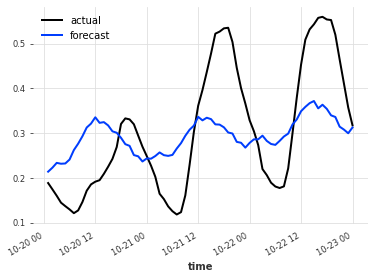

In [11]:


input_chunk_length = input_chunk_length = check_seasonality(demand, max_lag=240)[0]
output_chunk_length = 24
n_epochs=100


model_nbeats_one = NBEATSModel(input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, n_epochs=n_epochs, random_state=0)
model_nbeats_one.fit(train_demand, verbose=True)


pred_nbeats_one = model_nbeats_one.predict(n=24*3)

series_demand_scaled[-val:-val+72].plot(label='actual')
pred_nbeats_one.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_demand_scaled, pred_nbeats_one)))
print(f'RMSE: {rmse(series_demand_scaled, pred_nbeats_one)}')

MAPE = 20.02%
RMSE: 0.07893792477257207


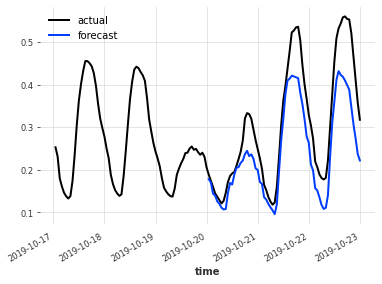

In [16]:

input_chunk_length = 24*7
output_chunk_length = 24
n_epochs=100


model_nbeats_one = NBEATSModel(input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, n_epochs=n_epochs, random_state=0)
model_nbeats_one.fit(train_demand, verbose=True)


pred_nbeats_one = model_nbeats_one.predict(n=24*3)

series_demand_scaled[-72-val:-val+72].plot(label='actual')
pred_nbeats_one.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_demand_scaled, pred_nbeats_one)))
print(f'RMSE = {rmse(series_demand_scaled, pred_nbeats_one)}')

## Training on Multiple Series
https://medium.com/unit8-machine-learning-publication/training-forecasting-models-on-multiple-time-series-with-darts-dc4be70b1844


MAPE = 9.81%
RMSE = 0.04235747650416645


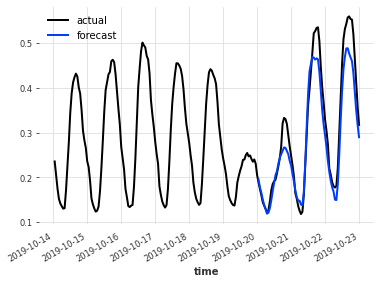

In [19]:
model_nbeats_mul = NBEATSModel(input_chunk_length=input_chunk_length, output_chunk_length=output_chunk_length, n_epochs=n_epochs, random_state=0)
model_nbeats_mul.fit([series_demand_scaled[:-val], series_wet_temp_scaled[:-val], series_dry_temp_scaled[:-val]], verbose=True)

pred_nbeats_mul = model_nbeats_mul.predict(n=24*3, series=series_demand_scaled[:-val])

series_demand_scaled[-val-72*2:-val+72].plot(label='actual')
pred_nbeats_mul.plot(label='forecast')
plt.legend();
print('MAPE = {:.2f}%'.format(mape(series_demand_scaled, pred_nbeats_mul)))
print(f'RMSE = {rmse(series_demand_scaled, pred_nbeats_mul)}')


RMSE = 0.029524617641421818
NRMSE = 13.934662071111957


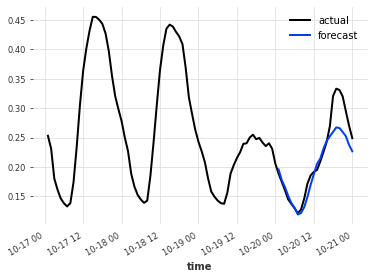

In [60]:
pred_nbeats_mul1 = model_nbeats_mul.predict(n=24, series=series_demand_scaled[:-val])

series_demand_scaled[-val-72:-val+24].plot(label='actual')
pred_nbeats_mul1.plot(label='forecast')
plt.legend();
print(f'RMSE = {rmse(series_demand_scaled, pred_nbeats_mul1)}')


nrmse = 100* rmse(series_demand_scaled, pred_nbeats_mul1)/(np.max(series_demand_scaled[-val:-val+24*1]["total_demand"].pd_series())-np.min(series_demand_scaled[-val:-val+24*1]["total_demand"].pd_series()))
print(f'NRMSE = {nrmse}')

RMSE = 0.034173135774257006
NRMSE = 8.186840504576669


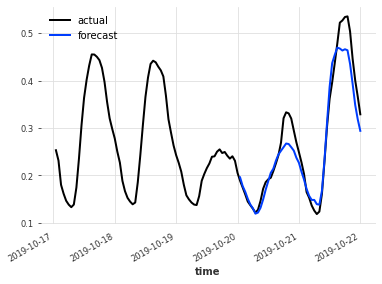

In [61]:
pred_nbeats_mul1 = model_nbeats_mul.predict(n=24*2, series=series_demand_scaled[:-val])

series_demand_scaled[-val-72:-val+24*2].plot(label='actual')
pred_nbeats_mul1.plot(label='forecast')
plt.legend();
print(f'RMSE = {rmse(series_demand_scaled, pred_nbeats_mul1)}')


nrmse = 100* rmse(series_demand_scaled, pred_nbeats_mul1)/(np.max(series_demand_scaled[-val:-val+24*2]["total_demand"].pd_series())-np.min(series_demand_scaled[-val:-val+24*2]["total_demand"].pd_series()))
print(f'NRMSE = {nrmse}')

# Linear model with future covariates

  0%|          | 0/631 [00:00<?, ?it/s]

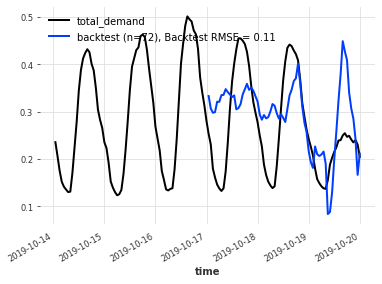

In [23]:
from darts.models import RegressionModel

regr_model = RegressionModel(lags=None,
                             lags_future_covariates=list(range(-9,0)))

regr_model.fit(train_demand,future_covariates=covariates)

train_demand[-72*2:].plot()
eval_model(regr_model,future_covariates=future_covariates)